# 3546 Deep Learning - Covid-19 deaths time series forecasting using a variational autoencoder



## April 10, 2019
## By:
* Thomas Liu de Almeida

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import argparse

from numpy.random import seed
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras import losses

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# print(deaths_df.shape)
# print(deaths_df.head)

deaths_df = pd.read_csv('/content/drive/My Drive/colab_dir/covid-19-forecasting/Siraj Raval/covid_08-09.csv')

# Create the simulated training and test sets

The geometric moving average dataset only contains data for 423 stocks. We will use stochastic simulation to augment the dataset.

The goal is not to model exactly the behavior of the geometric moving average time series of a given stock. We want the model to be trained on time series that are similar to a typical geometric moving average curve but without learning the specificities of the reference stock market dataset.

We will first load the geometric moving average created in notebook 1 (*3546 Deep Learning Project - Data Treatment.ipynb*) and then divide the dataset in two time periods of equal length.

## Import the geometric moving average dataset

In [ ]:
deaths_df.dropna(inplace = True)
deaths_df_T = deaths_df.T

### Divide in two time periods

In [ ]:
forecasting_size = 17
# deaths_df_p1 = deaths_df.head(int(len(deaths_df)/2))
# deaths_df_p2 = deaths_df.tail(int(len(deaths_df)/2))
deaths_df_p1 = deaths_df.head(len(deaths_df) - forecasting_size)
deaths_df_p2 = deaths_df.tail(len(deaths_df) - forecasting_size)

In [ ]:
print('len(deaths_df_p1) =', len(deaths_df_p1))
print('len(deaths_df_p2) =', len(deaths_df_p2))

len(deaths_df_p1) = 157
len(deaths_df_p2) = 157


## Create a training and test dataset

The training set will be 80% of the simulated paths.

In [ ]:
train = deaths_df_p1.T.values
test = deaths_df_p2.T.values

# train_size = int(train.shape[1]*0.8)



In [ ]:
# We split the simulated time series into a training and test set
# x_train = shuffled_array[0:8000]
# x_test = shuffled_array[8000:]

# x_train = train[:, 0:train_size]
# x_test = test[:, 0:train_size]
# y_train = train[:, train_size:-1]
# y_test = test[:, train_size:-1]

x_train = train[:, 0:train.shape[1] - forecasting_size ]
x_test = test[:, 0:test.shape[1] - forecasting_size]
y_train = train[:, train.shape[1] - forecasting_size  : train.shape[1]]
y_test = test[:, test.shape[1] - forecasting_size : test.shape[1]]
# y_train = train[:,  forecasting_size  : train.shape[1]]
# y_test = test[:,  forecasting_size : test.shape[1]]

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train)
print(y_test)


(1, 140)
(1, 140)
[[ 97240  98493  99572 100477 101049 101752 103026 104201 105463 106523
  107232 107852 108536 109888 111100 112304 113358]]
[[114250 114744 115309 116580 117665 118649 119504 120462 120828 121381
  122596 123780 124614 125521 126203 126650 126960]]


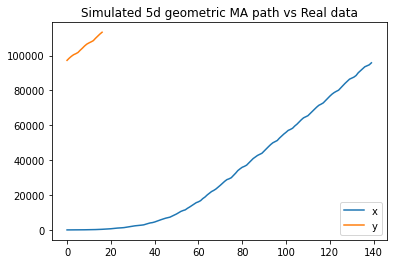

In [ ]:
# Let's plot a generated sample against a real geometric time series curve
fig, ax = plt.subplots()
ax.plot(x_train[0], label = 'x')
ax.plot(y_train[0], label = 'y')
ax.set_title('Simulated 5d geometric MA path vs Real data')
Legend = ax.legend(loc='lower right')

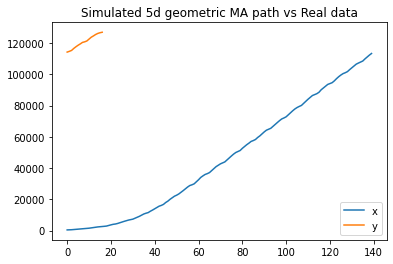

In [ ]:
# Let's plot a generated sample against a real geometric time series curve
fig, ax = plt.subplots()
ax.plot(x_test[0], label = 'x')
ax.plot(y_test[0], label = 'y')
ax.set_title('Simulated 5d geometric MA path vs Real data')
Legend = ax.legend(loc='lower right')

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1, 140)
(1, 140)
(1, 17)
(1, 17)


# Variational Autoencoder Model

We will use a simple VAE architecture similar to the one described in the [Keras blog](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py).

Our main goal is to reduce the dimensions of a time series vector with 388 elements to a two dimensional point.

As described in the Keras tutorial, we first setup the network parameters:

In [ ]:
# network parameters
original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 30
batch_size = 128
latent_dim = 16
epochs = 100

Then we map inputs to the latent distribution parameters:

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [ ]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train[0].reshape(-1, 1))
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows



Min: 4.000000, Max: 113358.000000


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 140)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 510)          71910       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 510)          260610      dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            2555        dense_1[0][0]                    
____________________________________________________________________________________________

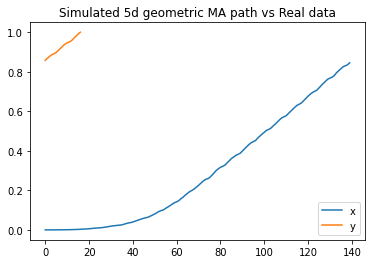

In [ ]:
image_size = x_train.shape[1]
original_dim = image_size 
output_dim = y_train.shape[1]

# mean_train = np.mean(train[0])
# mean_test = np.mean(test[0])

# max_train = np.max(np.abs(train[0] - mean_train))
# max_test = np.max(np.abs(test[0] - mean_test))

x_train_reshaped = np.reshape(x_train, [-1, original_dim])
x_test_reshaped = np.reshape(x_test, [-1, original_dim])
# x_train_normalized = (x_train_reshaped.astype('float32') - mean_train)/ max_train
# x_test_normalized = (x_train_reshaped.astype('float32') - mean_test) / max_test


y_train_reshaped = np.reshape(y_train, [-1, output_dim])
y_test_reshaped = np.reshape(y_test, [-1, output_dim])
# y_train_normalized = (y_train_reshaped.astype('float32') - mean_train) / max_train
# y_test_normalized = (y_test_reshaped.astype('float32') - mean_test)/ max_test

x_train_normalized = scaler.transform(x_train_reshaped)
x_test_normalized = scaler.transform(x_test_reshaped)


y_train_normalized = scaler.transform(y_train_reshaped)
y_test_normalized = scaler.transform(y_test_reshaped)

fig, ax = plt.subplots()
ax.plot(x_train_normalized[0], label = 'x')
ax.plot(y_train_normalized[0], label = 'y')
ax.set_title('Simulated 5d geometric MA path vs Real data')
Legend = ax.legend(loc='lower right')

# network parameters
input_shape = (original_dim, )
intermediate_dim = 510
batch_size = 128
latent_dim = 5
epochs = 1000

# input_shape = (original_dim, )
# intermediate_dim = 20
# batch_size = 12
# latent_dim = 5
# epochs = 1000

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x1 = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x1 = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x1)
outputs = Dense(output_dim, activation='sigmoid')(x)
# outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':
    # parser = argparse.ArgumentParser()
    # help_ = "Load h5 model trained weights"
    # parser.add_argument("-w", "--weights", help=help_)
    # help_ = "Use mse loss instead of binary cross entropy (default)"
    # parser.add_argument("-m",
    #                     "--mse",
    #                     help=help_, action='store_true')
    # args = parser.parse_args()
    models = (encoder, decoder)
    # data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    # if args.mse:
    # reconstruction_loss = mse(y_train_normalized, outputs)
    from keras.losses import msle
    reconstruction_loss = msle(y_train_normalized, outputs)
    # reconstruction_loss = mse(inputs, outputs)
    # else:
    # reconstruction_loss = binary_crossentropy(y_train_normalized, outputs)

    reconstruction_loss *= output_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    # vae_loss = K.mean(reconstruction_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    # if args.weights:
    #     vae.load_weights(args.weights)
    # else:
    if True:
        # train the autoencoder
        vae.fit(x_train_normalized, y_train_normalized,
                epochs=epochs,)
                # batch_size=batch_size,)
                # validation_data=(x_test, None))
        vae.save_weights('vae_mlp_mnist.h5')

    # plot_results(models,
    #              data,
    #              batch_size=batch_size,
    #              model_name="vae_mlp")

In [ ]:
z_mean, _, _ = encoder.predict(x_test_normalized,
                                   batch_size=batch_size)

# y_decoded = decoder.predict(z_mean)

In [ ]:
# y_decoded = decoder.predict(z_mean)*max_test*1.6 + mean_test*.8

In [ ]:
# y_decoded = decoder.predict(z_mean)*max_train*1.6 + mean_train*.8
y_decoded = decoder.predict(z_mean) 
# y_decoded = scaler.inverse_transform(y_decoded)

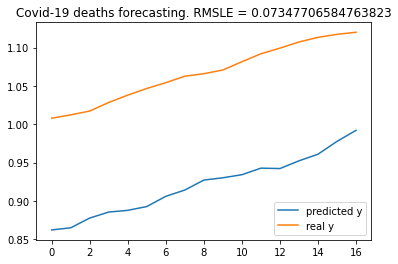

In [ ]:
fig, ax = plt.subplots()

# mean_dec = np.mean(y_decoded[0]) #80
# max_dec = np.max(y_decoded[0]) #1000
# min_dec = np.min(y_decoded[0])

# y_to_be_tested = y_train[0]
y_to_be_tested = y_test_normalized[0]

# mean_test = np.mean(y_to_be_tested) #80
# max_test = np.max(y_to_be_tested) #1000
# min_test = np.min(y_to_be_tested)

# delta_dec = max_dec - min_dec
# delta_test = max_test - min_test

rmsle = np.sqrt( mean_squared_log_error( y_to_be_tested, y_decoded[0] ))

# y_decoded_avg = moving_average(y_decoded[0], n=3)
# ax.plot( y_decoded_avg + y_to_be_tested[0] - y_decoded_avg[0] , label = 'predicted y')

# ax.plot( (y_decoded[0] - min_dec)*delta_test/delta_dec + min_test, label = 'predicted y')

# ax.plot( y_decoded[0] + y_to_be_tested[0] - y_decoded[0, 0] , label = 'predicted y')
ax.plot( y_decoded[0], label = 'predicted y' )

# ax.plot(y_test[0]*-1 + 2*mean_test, label = 'real y')
ax.plot(y_to_be_tested , label = 'real y')
ax.set_title('Covid-19 deaths forecasting. RMSLE = ' + str(rmsle))
Legend = ax.legend(loc='lower right')

In [ ]:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n:] / n